In [1]:
# %load 2comp_sed.py
#!/usr/bin/env python

### 1D sedimentation simulation

Solve a one-dimensional polydisperse sedimentation problem


$\phi_t + (f(\phi))_x = 0 $

Here $\phi$ is a vector of volume fractions $\in[0,1]$. f is a user-specified function
for the flux of particles.  
The variable state.q is the same as $\phi$. It follows the notation from Leveque's book "Finite Volume Methods for Hyperbolic Problems" 2001.

In [2]:
from __future__ import absolute_import
from clawpack import riemann
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# boundary conditions
def lowerwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,i,...] = qbc[:,2*num_ghost-1-i,...]

def upperwall(state,dim,t,qbc,auxbc,num_ghost):
    for i in range(num_ghost):
        qbc[:,-i-1,...] = qbc[:,-2*num_ghost+i,...]
        

def lowerdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.0,0.0])
    for i in range(num_ghost):
        qbc[:,i] = bvals

def upperdirichlet(state,dim,t,qbc,auxbc,num_ghost):
    nspecies = qbc.shape[0]
    bvals = np.array([0.0,0.])
    for i in range(num_ghost):
        qbc[:,-i-1] = bvals

In [4]:
def qinit(state,x0,u_rel,IC='dam-break'):
    xc = state.grid.x.centers

In [5]:
def runsim(qinit=None,num_output_times=10,tfinal=1,mx=51,IC='dam-break',
    use_petsc=False,kernel_language='Python',outdir='./_output',solver_type='classic'):

    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if kernel_language == 'Python':
        rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_fwave_1D
#         rs = riemann.advection_nonlinear_1D_py.advection_nonlinear_1D
    elif kernel_language == 'Fortran':
        print('No fortran solver available for advection_nonlinear_1D')
        pass

    if solver_type == 'classic':
        solver = pyclaw.ClawSolver1D(rs)
        solver.limiters = pyclaw.limiters.tvd.superbee
    elif solver_type == 'sharpclaw':
        solver = pyclaw.SharpClawSolver1D(rs)

    solver.kernel_language = kernel_language
    solver.cfl_desired = 0.9
    print('solver cfl',solver.cfl_desired)
    solver.order = 2
    print('solver order',solver.order)

    solver.bc_lower[0] = pyclaw.BC.custom
    solver.bc_upper[0] = pyclaw.BC.custom
    
    solver.user_bc_lower = lowerdirichlet
    solver.user_bc_upper = upperdirichlet

    xlower = 0.0
    xupper = 1.0
    mx = mx  # from kwargs
    x = pyclaw.Dimension(xlower,xupper,mx,name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 2
    state = pyclaw.State(domain,num_eqn)

    # Gravitational constant
    state.problem_data['u_rel'] = np.array([1.,1/30.])
    state.problem_data['efix'] = False
    state.problem_data['basis'] = None

    xc = state.grid.x.centers
    print(xc)
    if IC=='uniform-all':
        c0 = np.array([0.25,0.])
        # state defaults to empty. Convert to ones and fill with c0
        state.q = np.ones_like(state.q)*c0[:,np.newaxis]

    elif IC=='dam-break':
        # I changed state.is_valid() to always return true for fortran contiguity
        x0 = 0.2
        cr0 = np.array([0.4,0.01])
        cl0 = np.array([0.3,0.05])
        state.q = np.ones_like(state.q)
        state.q = cl0[:,np.newaxis]*(xc <= x0)[np.newaxis,:] + \
                  cr0[:,np.newaxis]*(xc >  x0)[np.newaxis,:]

    elif IC=='perturbation':
        x1 = 0.3
        x2 = 0.7
        eps = 0.5
        scale = 0.25
        state.q[0,:] = scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x1)/eps)**2)
#         state.q[0,-1] = 1.0
        state.q[1,:] = 0*scale*1/(np.sqrt(2*np.pi)*eps)*np.exp(-1/2*((xc-x2)/eps)**2)
    
    elif IC=='linear':
        c1 = 0.45
        c2 = 0
        dc1 = 0.01
        dc2 = 0.1
        state.q[0,:] = np.linspace(c1,c1+dc1,len(xc))
        state.q[1,:] = np.linspace(c2,c2+dc2,len(xc))
    
    claw = pyclaw.Controller()
    claw.keep_copy = True
    claw.num_output_times = num_output_times
    claw.tfinal = tfinal
    claw.solution = pyclaw.Solution(state,domain)
    claw.solver = solver
    claw.outdir = outdir
    print(state.problem_data)
    
    return claw

How does Q_ave influence to the total net flux?  
How does mass get lost? Sum the fluxes at the interface and see if they equal zero
> interface flux sum $\ne$0  
> compact support for flux removes conservation from F-wave solver

In [6]:
# %%capture
np.set_printoptions(precision=5,linewidth=np.inf)
ntimes = 50
mx = 101
tfinal = 3
claw = runsim(num_output_times=ntimes,tfinal=tfinal,mx=mx,
              IC='uniform-all')
claw.run()

solver cfl 0.9
solver order 2
[0.00495 0.01485 0.02475 0.03465 0.04455 0.05446 0.06436 0.07426 0.08416 0.09406 0.10396 0.11386 0.12376 0.13366 0.14356 0.15347 0.16337 0.17327 0.18317 0.19307 0.20297 0.21287 0.22277 0.23267 0.24257 0.25248 0.26238 0.27228 0.28218 0.29208 0.30198 0.31188 0.32178 0.33168 0.34158 0.35149 0.36139 0.37129 0.38119 0.39109 0.40099 0.41089 0.42079 0.43069 0.44059 0.4505  0.4604  0.4703  0.4802  0.4901  0.5     0.5099  0.5198  0.5297  0.5396  0.5495  0.55941 0.56931 0.57921 0.58911 0.59901 0.60891 0.61881 0.62871 0.63861 0.64851 0.65842 0.66832 0.67822 0.68812 0.69802 0.70792 0.71782 0.72772 0.73762 0.74752 0.75743 0.76733 0.77723 0.78713 0.79703 0.80693 0.81683 0.82673 0.83663 0.84653 0.85644 0.86634 0.87624 0.88614 0.89604 0.90594 0.91584 0.92574 0.93564 0.94554 0.95545 0.96535 0.97525 0.98515 0.99505]
{'u_rel': array([1.     , 0.03333]), 'efix': False, 'basis': None}
ascii
2019-04-23 11:27:17,160 INFO CLAW: Solution 0 computed for time t=0.000000
 Q average  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.61497e-08  0.00000e+00  1.52299e-07  0.00000e+00  1.52299e-07  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -1.84808e-06  0.00000e+00  0.00000e+00  0.00000e+00 -1.84808e-06  0.00000e+00]
 [ 5.71284e-02  0.00000e+00  7.93997e-02 -0.00000e+00  7.93997e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.80430e-01  0.00000e+00  2.60577e-02  0.00000e+00  2.60577e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.48301e-01  0.00000e+00  1.30657e-05  0.00000e+00  1.30657e-05  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.50000e-01  0.00000e+00  1.94289e-16  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.50000e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.50000e-01  0.00000e+00  0.00000e+00  0.00000

/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py:91: RuntimeWarning: invalid value encountered in true_divide
  J  = (J1-J0)/dx


 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.60139e-09  0.00000e+00  3.20279e-09  0.00000e+00  3.20279e-09  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.99314e-05  0.00000e+00  1.39798e-04  0.00000e+00  1.39798e-04  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -2.91831e-04  0.00000e+00  0.00000e+00  0.00000e+00 -2.91831e-04  0.00000e+00]
 [ 1.10249e-02  0.00000e+00  2.09076e-02  0.00000e+00  2.09076e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.15621e-01  0.00000e+00  8.26856e-02 -0.00000e+00  8.26856e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.29490e-01  0.00000e+00  2.02763e-03  0.00000e+00  2.02763e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.49970e-01  0.00000e+00  4.06731e-09  0.00000e+00  4.06731e-09  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.50000e-01  0.00000e+00 -1.38778e-17  0.00000e+00  0.00000e+00  

ascii
2019-04-23 11:27:17,395 INFO CLAW: Solution 2 computed for time t=0.120000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.68804e-14  0.00000e+00  3.37607e-14  0.00000e+00  3.37607e-14  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.59922e-06  0.00000e+00  3.19841e-06  0.00000e+00  3.19841e-06  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.26336e-03  0.00000e+00  2.50126e-03  0.00000e+00  2.50126e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.95411e-04  0.00000e+00 -4.04421e-03  0.00000e+00 -4.04421e-03  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.20008e-03  0.00000e+00  2.03042e-02  0.00000e+00  2.03042e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.10459e-01  0.00000e+00  8.37601e-02 -0.00000e+00  8.37601e-02  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.25396e-01  0.00000e+00  2.94406e-03  0.00000e+00  2.94406e-03  0.00000e+00  0.00000e+00  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.95001e-27  0.00000e+00  3.90003e-27  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.77242e-11  0.00000e+00  3.54483e-11  0.00000e+00  3.54483e-11  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.93544e-10  0.00000e+00  1.11619e-09  0.00000e+00  1.11619e-09  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.15065e-09  0.00000e+00 -1.97622e-12  0.00000e+00 -1.97622e-12  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.28786e-05  0.00000e+00  2.57530e-05  0.00000e+00  2.57530e-05  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -6.47317e-05  0.00000e+00  0.00000e+00  0.00000e+00 -6.47317e-05  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  4.15663e-05  0.00000e+00  0.00000e+00  0.00000e+00  4.15663e-05  0.00000e+00]
 [ 4.58420e-02  0.00000e+00  6.87036e-02 -0.00000

 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]]
[24.84032  0.       0.       0.       0.10547  0.      -0.10547  0.     ]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.95001e-37  0.00000e+00  3.90003e-37  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.77242e-21  0.00000e+00  3.54483e-21  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.51874e-18  0.00000e+00  3.03040e-18  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.41512e-16  0.00000e+00  8.76956e-16  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.22944e-07  0.00000e+00  2.45888e-07  0.00000e+00  2.45888e-07  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.46807e-05  0.00000e+00  2.88671e-05  0.00000e+00  2.88671e-05  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.25422e-40  0.00000e+00  4.50844e-40  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.04891e-24  0.00000e+00  4.09783e-24  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.99660e-21  0.00000e+00  3.98501e-21  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.18913e-19  0.00000e+00  1.42985e-18  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.41232e-10  0.00000e+00  2.82464e-10  0.00000e+00  2.82464e-10  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.22905e-08  0.00000e+00  6.40160e-08  0.00000e+00  6.40160e-08  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.27049e-06  0.00000e+00  4.41232e-06  0.00000e+00  4.41232e-06  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.36260e-04  0.00000e+00  1.45711e-03  0.00000e+00  1.45711e-03  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.25422e-42  0.00000e+00  4.50844e-42  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.04891e-26  0.00000e+00  4.09783e-26  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.21789e-23  0.00000e+00  4.42758e-23  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.34528e-21  0.00000e+00  1.86019e-20  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.41230e-12  0.00000e+00  2.82460e-12  0.00000e+00  2.82460e-12  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.75128e-10  0.00000e+00  9.44606e-10  0.00000e+00  9.44606e-10  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.06211e-08  0.00000e+00  9.93474e-08  0.00000e+00  9.93474e-08  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.87157e-05  0.00000e+00  1.37174e-04  0.00000e+00  1.37174e-04  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.60588e-53  0.00000e+00  5.21175e-53  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.36854e-37  0.00000e+00  4.73709e-37  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.86561e-34  0.00000e+00  7.72175e-34  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.77783e-31  0.00000e+00  5.54020e-31  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.63263e-23  0.00000e+00  3.26525e-23  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.44651e-20  0.00000e+00  2.88650e-20  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.57455e-18  0.00000e+00  1.10913e-17  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.71780e-15  0.00000e+00  3.41336e-15  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.60588e-63  0.00000e+00  5.21175e-63  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.36855e-47  0.00000e+00  4.73709e-47  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.14463e-44  0.00000e+00  1.02798e-43  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.14142e-41  0.00000e+00  1.02623e-40  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.63265e-33  0.00000e+00  3.26530e-33  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.32814e-30  0.00000e+00  4.64974e-30  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.52893e-27  0.00000e+00  3.04855e-27  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.61997e-25  0.00000e+00  1.31789e-24  0.00000e+00  0.00000e+00  

ascii
2019-04-23 11:27:17,804 INFO CLAW: Solution 6 computed for time t=0.360000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.01239e-66  0.00000e+00  6.02478e-66  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.73804e-50  0.00000e+00  5.47608e-50  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.26917e-47  0.00000e+00  1.25274e-46  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.64563e-44  0.00000e+00  1.32662e-43  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.88735e-36  0.00000e+00  3.77470e-36  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.91326e-33  0.00000e+00  5.81897e-33  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.08585e-30  0.00000e+00  4.16006e-30  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.01239e-78  0.00000e+00  6.02479e-78  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.73804e-62  0.00000e+00  5.47608e-62  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.04343e-59  0.00000e+00  1.60759e-58  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.11870e-55  0.00000e+00  2.23418e-55  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.88740e-48  0.00000e+00  3.77481e-48  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.13628e-45  0.00000e+00  8.26501e-45  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.30376e-42  0.00000e+00  8.59098e-42  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.88454e-39  0.00000e+00  5.75188e-39  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.48233e-79  0.00000e+00  6.96465e-79  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.16517e-63  0.00000e+00  6.33034e-63  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.32856e-60  0.00000e+00  1.86445e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.30213e-56  0.00000e+00  2.60053e-56  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.18184e-49  0.00000e+00  4.36368e-49  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.80247e-46  0.00000e+00  9.59620e-46  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.02100e-43  0.00000e+00  1.00228e-42  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.38224e-40  0.00000e+00  6.74441e-40  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.48233e-81  0.00000e+00  6.96466e-81  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.16517e-65  0.00000e+00  6.33035e-65  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.67040e-62  0.00000e+00  1.93281e-61  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.40288e-58  0.00000e+00  2.80189e-58  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.18185e-51  0.00000e+00  4.36370e-51  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.03810e-48  0.00000e+00  1.00675e-47  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.53965e-45  0.00000e+00  1.10592e-44  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.92446e-42  0.00000e+00  7.82678e-42  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.48233e-89  0.00000e+00  6.96466e-89  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.16518e-73  0.00000e+00  6.33035e-73  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.10378e-69  0.00000e+00  2.20629e-69  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.84278e-66  0.00000e+00  3.68114e-66  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.18192e-59  0.00000e+00  4.36384e-59  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 5.98068e-56  0.00000e+00  1.19526e-55  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.86873e-53  0.00000e+00  1.57136e-52  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.68097e-50  0.00000e+00  1.33305e-49  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.48233e-91  0.00000e+00  6.96466e-91  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.16517e-75  0.00000e+00  6.33035e-75  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.13796e-71  0.00000e+00  2.27465e-71  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.96198e-68  0.00000e+00  3.91941e-68  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.18194e-61  0.00000e+00  4.36388e-61  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 6.21633e-58  0.00000e+00  1.24239e-57  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.51463e-55  0.00000e+00  1.70044e-54  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.53074e-52  0.00000e+00  1.50274e-51  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 4.02557e-92  0.00000e+00  8.05114e-92  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 3.65894e-76  0.00000e+00  7.31788e-76  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 1.31899e-72  0.00000e+00  2.63652e-72  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.28067e-69  0.00000e+00  4.55606e-69  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 2.52232e-62  0.00000e+00  5.04465e-62  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 7.21027e-59  0.00000e+00  1.44104e-58  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 9.91183e-56  0.00000e+00  1.97948e-55  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 8.79993e-53  0.00000e+00  1.75602e-52  0.00000e+00  0.00000e+00  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.02558e-104  0.00000e+000  8.05115e-104  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.65895e-088  0.00000e+000  7.31789e-088  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.55609e-084  0.00000e+000  3.11072e-084  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.19937e-081  0.00000e+000  6.39252e-081  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.52250e-074  0.00000e+000  5.04500e-074  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.84478e-071  0.00000e+000  1.76795e-070  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.50253e-067  0.00000e+000  3.00152e-067  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.65356e-105  0.00000e+000  9.30713e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.22974e-089  0.00000e+000  8.45948e-089  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.80290e-085  0.00000e+000  3.60410e-085  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.71573e-082  0.00000e+000  7.42425e-082  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.91601e-075  0.00000e+000  5.83202e-075  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02525e-071  0.00000e+000  2.04934e-071  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.74673e-068  0.00000e+000  3.48935e-068  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.65357e-107  0.00000e+000  9.30713e-107  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.22974e-091  0.00000e+000  8.45948e-091  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.84858e-087  0.00000e+000  3.69546e-087  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.91044e-084  0.00000e+000  7.81348e-084  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.91605e-077  0.00000e+000  5.83210e-077  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05675e-073  0.00000e+000  2.11232e-073  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.85745e-070  0.00000e+000  3.71067e-070  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.65357e-115  0.00000e+000  9.30713e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.22974e-099  0.00000e+000  8.45949e-099  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.03130e-095  0.00000e+000  4.06091e-095  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.73861e-092  0.00000e+000  9.46909e-092  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.91624e-085  0.00000e+000  5.83247e-085  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18272e-081  0.00000e+000  2.36428e-081  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.33436e-078  0.00000e+000  4.66399e-078  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.65357e-117  0.00000e+000  9.30713e-117  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.22975e-101  0.00000e+000  8.45949e-101  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.07699e-097  0.00000e+000  4.15228e-097  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.95798e-094  0.00000e+000  9.90766e-094  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.91629e-087  0.00000e+000  5.83257e-087  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.21422e-083  0.00000e+000  2.42727e-083  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.46209e-080  0.00000e+000  4.91933e-080  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.37952e-118  0.00000e+000  1.07590e-117  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.88958e-102  0.00000e+000  9.77917e-102  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.40568e-098  0.00000e+000  4.80941e-098  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.75445e-095  0.00000e+000  1.14993e-094  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.37123e-088  0.00000e+000  6.74246e-088  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.40687e-084  0.00000e+000  2.81239e-084  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.85964e-081  0.00000e+000  5.71366e-081  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.37953e-130  0.00000e+000  1.07591e-129  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.88959e-114  0.00000e+000  9.77918e-114  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.72253e-110  0.00000e+000  5.44311e-110  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.39886e-107  0.00000e+000  1.47868e-106  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.37165e-100  0.00000e+000  6.74329e-100  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.62534e-096  0.00000e+000  3.24933e-096  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.83026e-093  0.00000e+000  7.65403e-093  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.21873e-131  0.00000e+000  1.24375e-130  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.65237e-115  0.00000e+000  1.13047e-114  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.15267e-111  0.00000e+000  6.30307e-111  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.58327e-108  0.00000e+000  1.71539e-107  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.89763e-101  0.00000e+000  7.79526e-101  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.88263e-097  0.00000e+000  3.76370e-097  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.44580e-094  0.00000e+000  8.88408e-094  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.21873e-135  0.00000e+000  1.24375e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.65237e-119  0.00000e+000  1.13047e-118  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27476e-115  0.00000e+000  6.54725e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.27083e-112  0.00000e+000  1.85286e-111  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.89782e-105  0.00000e+000  7.79564e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.96682e-101  0.00000e+000  3.93208e-101  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.85699e-098  0.00000e+000  9.70612e-098  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.21872e-139  0.00000e+000  1.24374e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.65237e-123  0.00000e+000  1.13047e-122  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.39685e-119  0.00000e+000  6.79144e-119  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.98477e-116  0.00000e+000  1.99560e-115  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.89803e-109  0.00000e+000  7.79605e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05101e-105  0.00000e+000  4.10047e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.28637e-102  0.00000e+000  1.05645e-101  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.21873e-141  0.00000e+000  1.24375e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.65237e-125  0.00000e+000  1.13047e-124  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.45790e-121  0.00000e+000  6.91354e-121  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03516e-117  0.00000e+000  2.06894e-117  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.89813e-111  0.00000e+000  7.79626e-111  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.09311e-107  0.00000e+000  4.18467e-107  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.50787e-104  0.00000e+000  1.10074e-103  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.21872e-143  0.00000e+000  1.24374e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.65237e-127  0.00000e+000  1.13047e-126  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.51894e-123  0.00000e+000  7.03563e-123  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.07251e-119  0.00000e+000  2.14361e-119  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.89825e-113  0.00000e+000  7.79649e-113  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.13521e-109  0.00000e+000  4.26887e-109  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.73393e-106  0.00000e+000  1.14593e-105  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.00709e-102  0.00000e+000  2.01189e-102  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.18884e-144  0.00000e+000  1.43777e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.53414e-128  0.00000e+000  1.30683e-127  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.07417e-124  0.00000e+000  8.14572e-124  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.24372e-120  0.00000e+000  2.48581e-120  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.50638e-114  0.00000e+000  9.01276e-114  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.47263e-110  0.00000e+000  4.94345e-110  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.65209e-107  0.00000e+000  1.32943e-106  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.18885e-154  0.00000e+000  1.43777e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.53414e-138  0.00000e+000  1.30683e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.42702e-134  0.00000e+000  8.85142e-134  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.47135e-130  0.00000e+000  2.94092e-130  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.50711e-124  0.00000e+000  9.01421e-124  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.71599e-120  0.00000e+000  5.43018e-120  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.03985e-117  0.00000e+000  1.60688e-116  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.18886e-156  0.00000e+000  1.43777e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.53415e-140  0.00000e+000  1.30683e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.49759e-136  0.00000e+000  8.99256e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.51916e-132  0.00000e+000  3.03651e-132  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.50727e-126  0.00000e+000  9.01453e-126  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.76467e-122  0.00000e+000  5.52753e-122  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.33318e-119  0.00000e+000  1.66553e-118  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.31032e-157  0.00000e+000  1.66206e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.55347e-141  0.00000e+000  1.51069e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.20645e-137  0.00000e+000  1.04099e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.76113e-133  0.00000e+000  3.52018e-133  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.21042e-127  0.00000e+000  1.04208e-126  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.20095e-123  0.00000e+000  6.39982e-123  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.66380e-120  0.00000e+000  1.93148e-119  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.31032e-159  0.00000e+000  1.66206e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.55348e-143  0.00000e+000  1.51070e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.28803e-139  0.00000e+000  1.05730e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.81736e-135  0.00000e+000  3.63261e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.21061e-129  0.00000e+000  1.04212e-128  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.25723e-125  0.00000e+000  6.51237e-125  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.00095e-121  0.00000e+000  2.00060e-121  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.57067e-166  0.00000e+000  9.14135e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.55347e-151  0.00000e+000  1.51069e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.61435e-147  0.00000e+000  1.12257e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05109e-143  0.00000e+000  4.09993e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.21144e-137  0.00000e+000  1.04229e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.48234e-133  0.00000e+000  6.96260e-133  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.14531e-129  0.00000e+000  2.28922e-129  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

ascii
2019-04-23 11:27:18,648 INFO CLAW: Solution 14 computed for time t=0.840000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.72661e-168  0.00000e+000  1.14532e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.73182e-154  0.00000e+000  1.74636e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.59286e-150  0.00000e+000  1.31822e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.44747e-146  0.00000e+000  4.89230e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.02470e-140  0.00000e+000  1.20494e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.09643e-136  0.00000e+000  8.19045e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.37137e-132  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.16254e-173  0.00000e+000  1.23251e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.73178e-164  0.00000e+000  1.74636e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.06438e-160  0.00000e+000  1.41253e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.81366e-156  0.00000e+000  5.62450e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.02611e-150  0.00000e+000  1.20522e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.42180e-146  0.00000e+000  8.84119e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.59961e-142  0.00000e+000  3.19744e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.85860e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.61864e-166  0.00000e+000  1.74409e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.16262e-162  0.00000e+000  1.43061e-161  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.88996e-158  0.00000e+000  5.77705e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.02642e-152  0.00000e+000  1.20528e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.48688e-148  0.00000e+000  8.97136e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.64736e-144  0.00000e+000  3.29293e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.62880e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.65698e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.31699e-163  0.00000e+000  1.66334e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.34873e-159  0.00000e+000  6.69413e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.96657e-153  0.00000e+000  1.39331e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.19352e-149  0.00000e+000  1.03842e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.90932e-145  0.00000e+000  3.81657e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.65416e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.68235e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.33404e-165  0.00000e+000  1.66117e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.43855e-161  0.00000e+000  6.87378e-161  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.96693e-155  0.00000e+000  1.39338e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.26876e-151  0.00000e+000  1.05347e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.96541e-147  0.00000e+000  3.92872e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.25689e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18780e-164  0.00000e+000  3.02698e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.21243e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.30147e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.96865e-161  0.00000e+000  1.39429e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.49450e-157  0.00000e+000  1.09862e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.13856e-153  0.00000e+000  4.27492e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.47528e-150  0.00000e+000  1.09420e-149  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.68783e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.76781e-164  0.00000e+000  5.87319e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.68070e-165  0.00000e+000 -9.87268e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.38728e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.69333e-163  0.00000e+000  1.39429e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.56977e-159  0.00000e+000  1.11368e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.19790e-155  0.00000e+000  4.39357e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.81172e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.22964e-165  0.00000e+000  1.40827e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.07571e-164  0.00000e+000  1.89722e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.20796e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.39424e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.64544e-161  0.00000e+000  1.12811e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.25805e-157  0.00000e+000  4.51385e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5

ascii
2019-04-23 11:27:18,860 INFO CLAW: Solution 16 computed for time t=0.960000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.53607e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.96387e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.05017e-164  0.00000e+000  9.81478e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.82148e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.01962e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.56935e-162  0.00000e+000  1.30999e-161  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.61657e-158  0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.25286e-164  0.00000e+000  1.45057e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.21877e-164  0.00000e+000 -2.45739e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.40622e-164  0.00000e+000  2.49488e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.03532e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.96370e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.24453e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  9.25218e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.60458e-164  0.00000e+000  3.20916e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.51449e-164  0.00000e+000  6.61066e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.53436e-163  0.00000e+000  1.10475e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.81368e-164  0.00000e+000 -3.81072e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.46973e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.28134e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.68565e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.54733e-165  0.00000e+000  7.09465e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.83422e-164  0.00000e+000  4.24950e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20250e-163  0.00000e+000  1.41321e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.38282e-163  0.00000e+000 -1.05259e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.83317e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.67576e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.59682e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.69795e-166  0.00000e+000  3.39589e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.26945e-164  0.00000e+000  6.47097e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.45516e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.78535e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.16658e-163  0.00000e+000  4.78542e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.16511e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  8.12180e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

2019-04-23 11:27:19,070 INFO CLAW: Solution 18 computed for time t=1.080000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.44424e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.25850e-165  0.00000e+000  1.74055e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.72236e-164  0.00000e+000  9.25248e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.03010e-165  0.00000e+000 -1.98912e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05595e-162  0.00000e+000  4.30276e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.97186e-162  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.34570e-165  0.00000e+000  6.69140e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.48337e-165  0.00000e+000  5.58394e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.96118e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.96704e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.97126e-161  0.00000e+000  1.19420e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.39845e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.20526e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.59488e-166  0.00000e+000  7.18975e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.19353e-164  0.00000e+000  4.24327e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -9.71915e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.26509e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.13904e-160  0.00000e+000  2.27810e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.56705e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.28999e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.43583e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.98088e-164  0.00000e+000  8.84893e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.72843e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.76669e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.89439e-160  0.00000e+000  3.78900e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.58924e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.80138e-160  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.82231e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.95615e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.27724e-165  0.00000e+000  1.26079e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.34639e-164  0.00000e+000  2.57656e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.47618e-159  0.00000e+000  4.95228e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -9.90621e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.95400e-159  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.68179e-166  0.00000e+000  1.33636e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -5.04285e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.74815e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.35349e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.94105e-159  0.00000e+000  1.78821e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.57659e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.78839e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  2.12029e-170  0.00000e+000  0.00000e+000  0.00000

ascii
2019-04-23 11:27:19,275 INFO CLAW: Solution 20 computed for time t=1.200000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.96629e-165  0.00000e+000  3.93258e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.79285e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.00864e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.93679e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.48427e-158  0.00000e+000  2.96854e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -5.93726e-158  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.25456e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14233e-165  0.00000e+000  6.79379e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.84776e-165  0.00000e+000 -5.38294e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -5.03522e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.67543e-157  0.00000e+000  7.35085e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.47017e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.35087e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.31177e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.03945e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.63158e-165  0.00000e+000  9.31763e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.20573e-165  0.00000e+000 -1.41693e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.98332e-157  0.00000e+000  1.39666e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.79333e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.39667e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.13204e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.59466e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.35166e-165  0.00000e+000  6.84867e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.32951e-165  0.00000e+000 -2.89297e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.15923e-156  0.00000e+000  2.31846e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.63693e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.31847e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.45471e-165  0.00000e+000  8.90942e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.80324e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  8.86312e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  9.60078e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.51072e-155  0.00000e+000  3.02145e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.04290e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.02145e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

ascii
2019-04-23 11:27:19,479 INFO CLAW: Solution 22 computed for time t=1.320000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30117e-165  0.00000e+000  2.60234e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.15643e-165  0.00000e+000 -2.89182e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.20740e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.51548e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.05316e-155  0.00000e+000  1.81063e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.62127e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.47205e-167  0.00000e+000  4.94410e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.31870e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.38099e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20801e-166  0.00000e+000  3.58840e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.24165e-153  0.00000e+000  4.48331e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.96661e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.48331e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.29260e-167  0.00000e+000  1.25852e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.09970e-167  0.00000e+000 -2.29710e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.90911e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.58840e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.25914e-153  0.00000e+000  8.51828e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.70366e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  8.51828e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.13418e-167  0.00000e+000  8.26837e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.27303e-167  0.00000e+000 -7.99067e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.01227e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.15150e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.07017e-153  0.00000e+000  1.41403e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.82807e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.41403e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.19627e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.99742e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.20143e-167  0.00000e+000  3.92626e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.81480e-167  0.00000e+000  7.30048e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.21392e-152  0.00000e+000  1.84278e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.68557e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.84278e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.48090e-168  0.00000e+000  1.49618e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.10362e-169  0.00000e+000 -2.81029e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  6.09274e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.08700e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.32623e-151  0.00000e+000  6.65245e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.33049e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  6.65245e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000 -4.62705e-179  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.95944e-168  0.00000e+000  9.91887e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.07567e-168  0.00000e+000 -1.16864e-167  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.97823e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.86730e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.52153e-151  0.00000e+000  1.10431e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.20861e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.10431e-150  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.11432e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -5.33198e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.13292e-168  0.00000e+000  3.47452e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.68106e-168  0.00000e+000  5.62176e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.19572e-150  0.00000e+000  1.43914e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.87829e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.43914e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.36382e-169  0.00000e+000  4.72764e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.23346e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.07179e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.41293e-168  0.00000e+000  3.53289e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.36719e-149  0.00000e+000  2.73437e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -5.46875e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.73437e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.89332e-169  0.00000e+000  1.17866e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.57540e-170  0.00000e+000 -2.30582e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  6.14660e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.53289e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.59765e-149  0.00000e+000  5.19531e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.03906e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.19531e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.95852e-169  0.00000e+000  7.91705e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.61001e-169  0.00000e+000 -1.06141e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.75963e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.07181e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.31211e-149  0.00000e+000  8.62421e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.72484e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  8.62421e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.07555e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.06383e-169  0.00000e+000  6.27877e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.63631e-169  0.00000e+000 -3.13380e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.23234e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.95767e-148  0.00000e+000  5.91535e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.18307e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.91535e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.51118e-171  0.00000e+000  1.10224e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.71741e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.54002e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.15107e-169  0.00000e+000  3.11718e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02867e-147  0.00000e+000  4.05734e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.11467e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.05734e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.79596e-170  0.00000e+000  5.59192e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.38835e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.18959e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.05984e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.36759e-147  0.00000e+000  6.73518e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.34704e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  6.73518e-147  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.35793e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.52496e-169  0.00000e+000  1.15215e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.35044e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.13751e-168  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.38868e-146  0.00000e+000  8.77735e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.75547e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  8.77735e-146  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.09509e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.87193e-169  0.00000e+000  5.93403e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18308e-169  0.00000e+000 -7.31173e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.24753e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.58431e-145  0.00000e+000  3.16862e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.33725e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.16862e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.03813e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.85263e-170  0.00000e+000  3.44678e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.38230e-169  0.00000e+000 -5.27078e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.07627e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.62996e-145  0.00000e+000  5.25992e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.05198e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.25992e-145  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.11729e-170  0.00000e+000  2.23458e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.13768e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.45082e-170  0.00000e+000  2.11862e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.69675e-169  0.00000e+000  4.98471e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.49415e-145  0.00000e+000  1.89883e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.79766e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.89883e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.23065e-170  0.00000e+000  2.46131e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.21246e-170  0.00000e+000  3.50231e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.53165e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.30989e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.42739e-144  0.00000e+000  6.85478e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.37096e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  6.85478e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

[ 2.47792e+01  0.00000e+00 -6.91179e-18  0.00000e+00  7.83162e-03  0.00000e+00 -7.83162e-03  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.96428e-172  0.00000e+000  1.99286e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.47662e-170  0.00000e+000  1.65547e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.66111e-170  0.00000e+000 -2.81857e-169  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.18090e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.51204e-144  0.00000e+000  1.30241e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.60481e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.57801e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.70118e-172  0.00000e+000  1.54963e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.39603e-170  0.00000e+000  7.20841e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.71449e-170  0.00000e+000 -6.57149e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05390e-143  0.00000e+000  4.10779e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.21559e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.10779e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.85669e-172  0.00000e+000  3.71338e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.91650e-171  0.00000e+000  1.90903e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.96537e-171  0.00000e+000 -3.49926e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  9.98595e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.08565e-142  0.00000e+000  1.01713e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.03426e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.01713e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.05220e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.95444e-171  0.00000e+000  5.51932e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.05724e-171  0.00000e+000  6.86280e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.18441e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.66274e-142  0.00000e+000  1.93255e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.86509e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.93255e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.93042e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.60286e-172  0.00000e+000  2.50666e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.22757e-171  0.00000e+000  1.12279e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.19891e-171  0.00000e+000 -1.92852e-170  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.60401e-141  0.00000e+000  3.20803e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.41606e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.20803e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.64623e-172  0.00000e+000  7.29246e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.99557e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.10318e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.93997e-171  0.00000e+000  4.99197e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.79049e-141  0.00000e+000  1.15810e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.31620e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.15810e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.85119e-171  0.00000e+000  3.70239e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.92153e-172  0.00000e+000 -6.62047e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.68816e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  9.03547e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.09037e-140  0.00000e+000  4.18074e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.36147e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.18074e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.17384e-172  0.00000e+000  8.34768e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02892e-171  0.00000e+000  3.88312e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.26620e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.63542e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.97170e-140  0.00000e+000  7.94340e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.58868e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.94340e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[24.77801  0.       0.       0.       0.0773   0.      -0.0773   0.     ]
ascii
2019-04-23 11:27:20,343 INFO CLAW: Solution 30 computed for time t=1.800000
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.71346e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.12090e-171  0.00000e+000  2.98448e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.84207e-172  0.00000e+000 -4.05786e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.25587e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25267e-139  0.00000e+000  2.50535e-139  0.00000e+000 

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[ 2.47957e+01  0.00000e+00  3.46945e-18  0.00000e+00  1.03283e-02  0.00000e+00 -1.03283e-02  0.00000e+00]
value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.81675e-174  0.00000e+000  1.16335e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.65696e-172  0.00000e+000  3.08125e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.46306e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.47185e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.89331e-138  0.00000e+000  1.17866e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.93110e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.74109e-172  0.00000e+000  6.06840e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.39201e-173  0.00000e+000 -1.06722e-171  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.54859e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.78290e-138  0.00000e+000  1.95658e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.91316e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.95658e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.02389e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.82334e-173  0.00000e+000  1.36945e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.05058e-172  0.00000e+000 -3.29580e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.70178e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.85875e-137  0.00000e+000  3.71750e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.43500e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.71750e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19319e-176  0.00000e+000  2.38639e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.64405e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.93609e-173  0.00000e+000  9.15551e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.69842e-172  0.00000e+000  2.09407e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.71009e-137  0.00000e+000  1.34202e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.68404e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.34202e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.18999e-173  0.00000e+000  2.37999e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -5.43364e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.97216e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.70457e-173  0.00000e+000  9.92203e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.27492e-136  0.00000e+000  2.54983e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -5.09967e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.54983e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.82212e-174  0.00000e+000  1.16442e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.06623e-173  0.00000e+000  1.80361e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.56395e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.79589e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.60245e-136  0.00000e+000  9.20490e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.84098e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  9.20490e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.62094e-174  0.00000e+000  3.24187e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.31820e-173  0.00000e+000  5.98803e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.65511e-174  0.00000e+000 -1.10934e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.57818e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.64007e-136  0.00000e+000  1.52801e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.05603e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.52801e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80993e-175  0.00000e+000  7.61986e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27189e-173  0.00000e+000  6.39138e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.89514e-174  0.00000e+000 -1.09561e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.08487e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-136  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.52747e-151  0.00000e+000 -3.31593e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80993e-175  0.00000e+000  7.61986e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27189e-173  0.00000e+000  6.39138e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.89514e-174  0.00000e+000 -1.09561e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.08487e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-136  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80993e-175  0.00000e+000  7.61986e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27189e-173  0.00000e+000  6.39138e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.89514e-174  0.00000e+000 -1.09561e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.08487e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-136  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80993e-175  0.00000e+000  7.61986e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27189e-173  0.00000e+000  6.39138e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.89514e-174  0.00000e+000 -1.09561e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.08487e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-136  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80993e-175  0.00000e+000  7.61986e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27189e-173  0.00000e+000  6.39138e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.89514e-174  0.00000e+000 -1.09561e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.08487e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-136  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80993e-175  0.00000e+000  7.61986e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27189e-173  0.00000e+000  6.39138e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.89514e-174  0.00000e+000 -1.09561e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.08487e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-136  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.80993e-175  0.00000e+000  7.61986e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.27189e-173  0.00000e+000  6.39138e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.89514e-174  0.00000e+000 -1.09561e-172  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.08487e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-136  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-135  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.76563e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.09706e-174  0.00000e+000  1.77254e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.24927e-173  0.00000e+000  1.50658e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.05619e-174  0.00000e+000 -5.59388e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-137  0.00000e+000  1.65796e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-136  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.07421e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.00790e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.39406e-174  0.00000e+000  2.05349e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.07880e-173  0.00000e+000  2.25292e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-138  0.00000e+000  1.65796e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-137  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.88132e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.50936e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02642e-175  0.00000e+000  3.80026e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.08941e-173  0.00000e+000  1.77827e-173  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-139  0.00000e+000  1.65796e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05494e-151  0.00000e+000 -3.31593e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-138  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.64804e-175  0.00000e+000  1.32961e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.29811e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.81710e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.67074e-175  0.00000e+000  5.02749e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-140  0.00000e+000  1.65796e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05643e-151  0.00000e+000 -3.31593e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-139  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.58054e-174  0.00000e+000  3.16109e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.31472e-175  0.00000e+000 -5.05924e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.74762e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.02749e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-141  0.00000e+000  1.65796e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000 -3.31593e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-140  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.43012e-175  0.00000e+000  6.86024e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.72540e-174  0.00000e+000  2.07876e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.97022e-176  0.00000e+000 -5.49017e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  9.09976e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.28982e-142  0.00000e+000  1.65796e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000 -3.31593e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.65796e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.07113e-176  0.00000e+000  1.21423e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.30796e-174  0.00000e+000  2.37308e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.65786e-175  0.00000e+000 -3.25743e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.27486e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.52371e-142  0.00000e+000  7.04743e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000 -1.40949e-141  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.04743e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/pyclaw/limiters/tvd.py:107: RuntimeWarning: overflow encountered in square
  wave_norm2 = np.sum(np.square(wave),axis=0)
/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/pyclaw/limiters/tvd.py:114: RuntimeWarning: overflow encountered in multiply
  dotls = np.sum(wave[:,:,1:]*wave[:,:,:-1],axis=0)
/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/pyclaw/limiters/tvd.py:122: RuntimeWarning: invalid value encountered in multiply
  r = np.ma.array((spos*dotls[:,:-1] + (1-spos)*dotls[:,1:]))
/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py:307: RuntimeWarning: invalid value encountered in less
  if (q_ave<0).any():
/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/advection_nonlinear_1D_py.py:309: RuntimeWarning: invalid value encountered in less
  q_ave[q_ave<0] = 0.
/home/ubuntu/miniconda3/lib/python3.6/site-packages/clawpack/riemann/adve

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -8.91821e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.61460e-175  0.00000e+000  7.01285e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.89083e-174  0.00000e+000  2.55745e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.65880e-175  0.00000e+000 -5.20734e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.52371e-143  0.00000e+000  7.04743e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000 -1.40949e-142  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.04743e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.04760e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -6.21049e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 5.57341e-175  0.00000e+000  1.31984e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.81587e-174  0.00000e+000  1.19722e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.52371e-144  0.00000e+000  7.04743e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000 -1.40949e-143  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  7.04743e-144  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.03004e-163  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.95886e-175  0.00000e+000  1.99177e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.23982e-176  0.00000e+000 -3.89875e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.85397e-174  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.27716e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19806e-148  0.00000e+000  2.39613e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000 -4.78614e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.39001e-148  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.32125e-175  0.00000e+000  4.64251e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.11066e-175  0.00000e+000 -7.06370e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  1.59618e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  5.85545e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19806e-149  0.00000e+000  2.39613e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000 -4.73112e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  2.33500e-149  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1

 [ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]]
[nan nan nan nan nan nan nan nan]
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.50595e-177  0.00000e+000  9.01190e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.06407e-176  0.00000e+000  1.23258e-175  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.95365e-176  0.00000e+000 -6.54659e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.14288e-176  0.00000e+000 -9.07496e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.19806e-151  0.00000e+000  2.39613e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.05652e-151  0.00000e+000  1.32079e-151  0.00000e+000  0.00000e+000  0.00000e+00

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -4.23986e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.27952e-176  0.00000e+000  3.40701e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 7.83454e-176  0.00000e+000  9.70304e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.02527e-176  0.00000e+000 -7.32157e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.00885e-153  0.00000e+000  1.80177e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.38391e-151  0.00000e+000  2.40746e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.96643e-151  0.00000e+000  7.57584e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.67261e-151  0.00000e+000 -3.34522e-151  0.00000e+000  0.00000e+000  0.00000

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.95714e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.70893e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.17641e-176  0.00000e+000  5.08604e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.17193e-176  0.00000e+000  6.90500e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.00885e-155  0.00000e+000  1.80177e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.02425e-152  0.00000e+000  4.01246e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.55027e-151  0.00000e+000  2.29444e-151  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2

[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 6.71162e-178  0.00000e+000  1.34232e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -7.29711e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  6.55622e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.89040e-176  0.00000e+000  5.66051e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 9.00885e-157  0.00000e+000  1.80177e-156  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.99720e-154  0.00000e+000  5.95837e-154  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.30243e-152  0.00000e+000  6.48533e-152  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.69871e-151  0.00000e+000  2.08840e-151  0.00000e+000  0.00000e+000  0.00000

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.71155e-177  0.00000e+000  5.42309e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.57050e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  4.53224e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.02243e-176  0.00000e+000  3.19479e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.04142e-157  0.00000e+000  2.08285e-157  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.56466e-155  0.00000e+000  7.08766e-155  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.14974e-153  0.00000e+000  8.15731e-153  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.94303e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 3.92337e-176  0.00000e+000  8.23534e-176  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 4.21775e-165  0.00000e+000  8.43551e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -1.87215e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000  3.85562e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.01544e-164  0.00000e+000  3.31696e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [  

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.90021e-177  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -3.79598e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 8.84644e-165  0.00000e+000  1.84521e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 2.15823e-165  0.00000e+000 -3.18285e-164  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [  

value in q_ave < 0
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 1.25267e-166  0.00000e+000  2.50535e-166  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [ 0.00000e+000  0.00000e+000 -2.70046e-165  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000  0.00000e+000]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan           nan           nan           nan]
 [          nan           nan           nan           nan           nan           nan           nan 

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan 

ascii
2019-04-23 11:27:21,392 INFO CLAW: Solution 39 computed for time t=2.340000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan 

ascii
2019-04-23 11:27:21,509 INFO CLAW: Solution 45 computed for time t=2.700000
 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [

 Q average           Total net flux    right-moving flux   left-moving flux
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan 

{'cflmax': 0.9000077264534486,
 'dtmin': 4.349775072405376e-119,
 'dtmax': 0.023277429545526702,
 'numsteps': 276}

(101, 102)


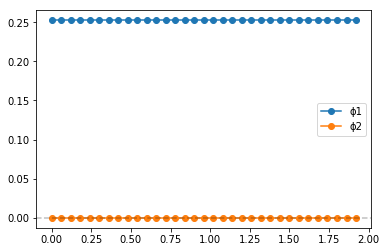

In [7]:
xs = np.linspace(0,1,mx)
times = np.linspace(0,tfinal,ntimes+1)
dx = xs[1]-xs[0]

result = np.vstack([frame.q for frame in claw.frames]).T
print(result.shape)

plt.plot(times,np.sum(result[:,0::2],axis=0)*dx,'o-')
plt.plot(times,np.sum(result[:,1::2],axis=0)*dx,'o-')
plt.axhline(y=0,color='black',linestyle='--',alpha=0.25)
plt.legend(['ϕ1','ϕ2'])
plt.show()

nan

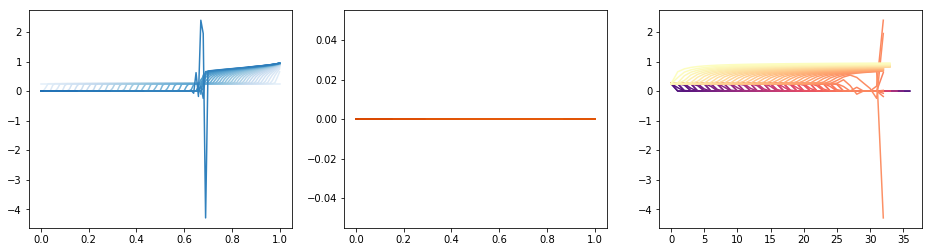

In [8]:
color1 = iter(plt.get_cmap('Blues')(np.linspace(0.1,1,ntimes)))
color2 = iter(plt.get_cmap('Oranges')(np.linspace(0.1,1,ntimes)))
tcol1  = iter(plt.get_cmap('magma')(np.linspace(0.25,1,mx)))

fig,ax = plt.subplots(ncols=3,figsize=(16,4))
for j,color in enumerate((color1,color2,tcol1)):
    if j<2:
        for i in range(ntimes):
            ax[j].plot(xs,result[:,j+2*i],color=next(color))
    else:
        pass
        for x in range(mx):
            ax[j].plot(np.arange(ntimes+1),result[x,0::2],color=next(color),label=str(x+1))
# ax[2].legend(loc=0,frameon=False)
result[-1,-2:].sum()

2019-04-23 11:27:22,795 INFO CLAW: Animation.save using <class 'clawpack.visclaw.JSAnimation.html_writer.HTMLWriter'>



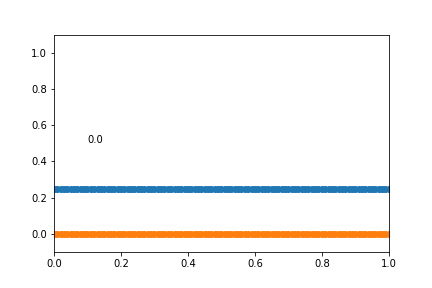
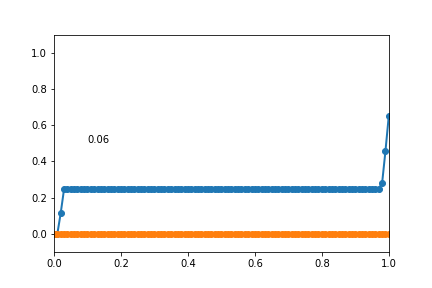
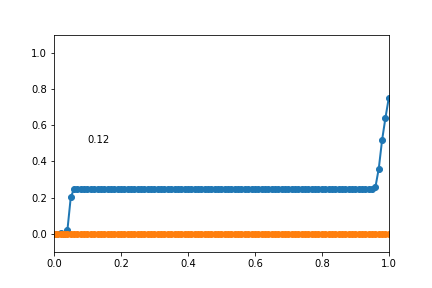
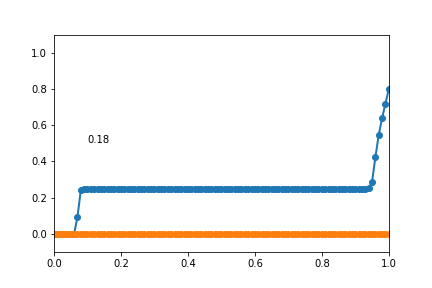
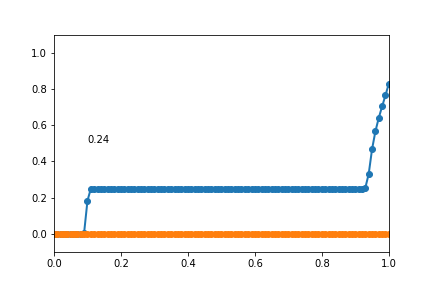
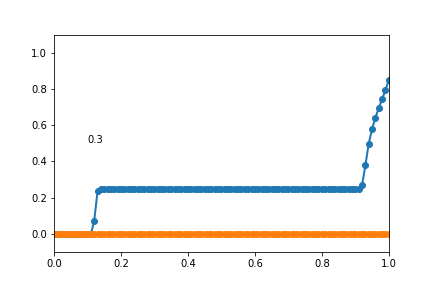
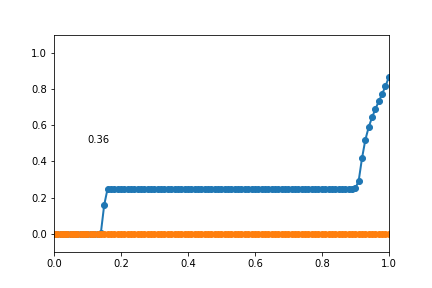
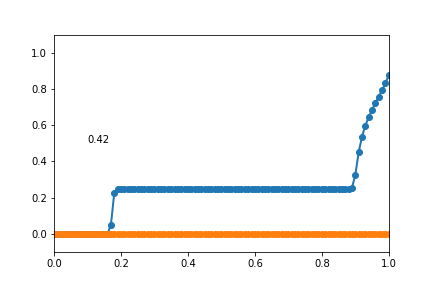
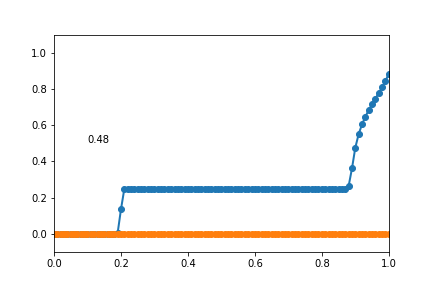
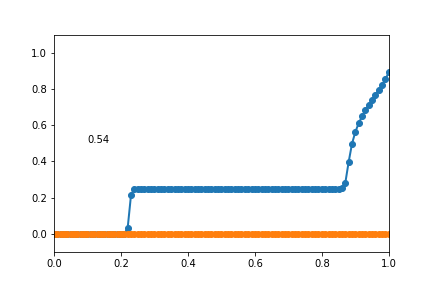
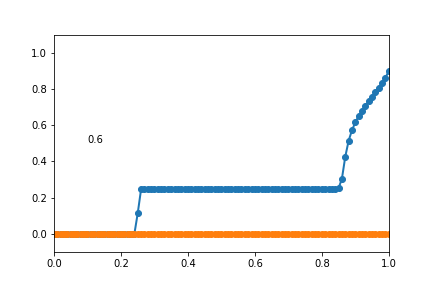
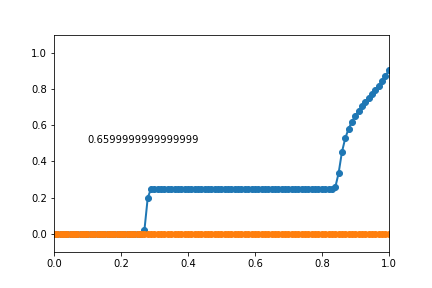
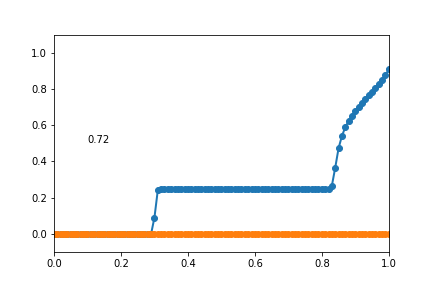
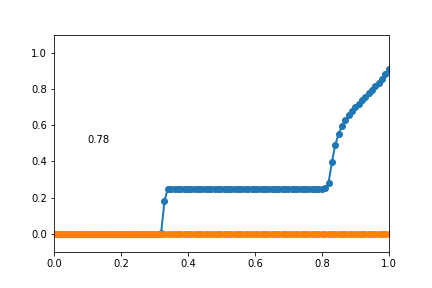
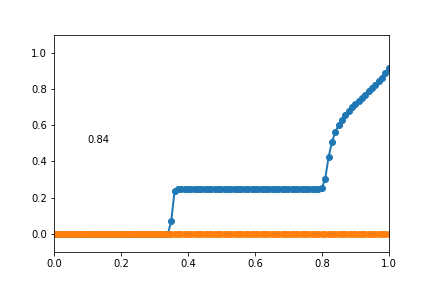
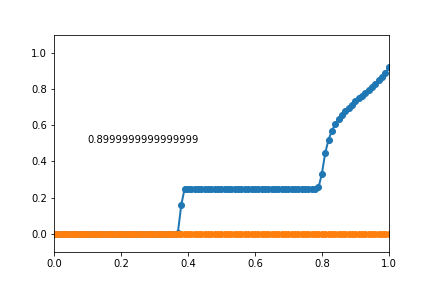
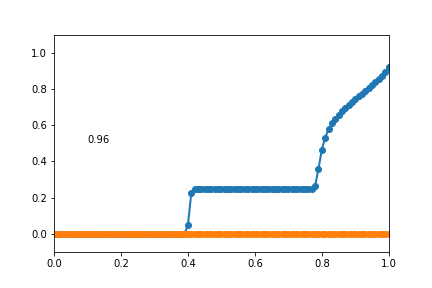
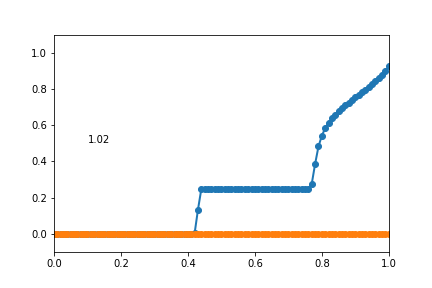
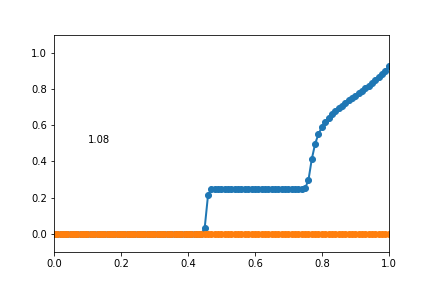
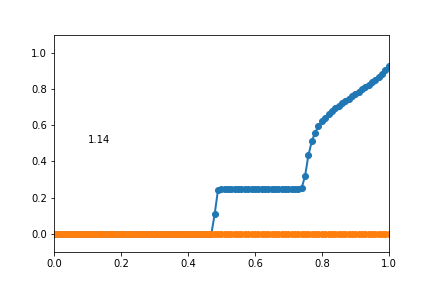
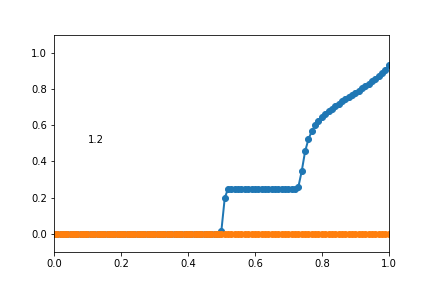
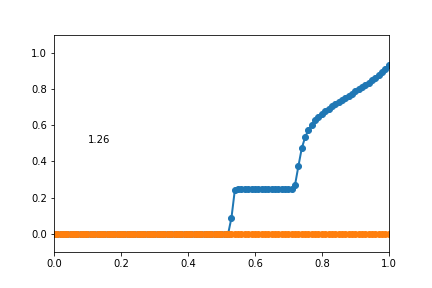
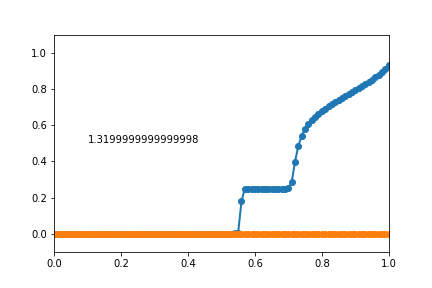
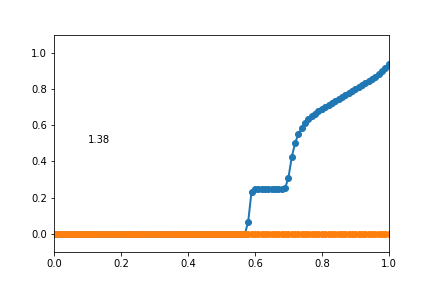
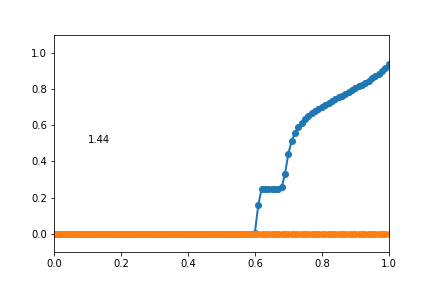
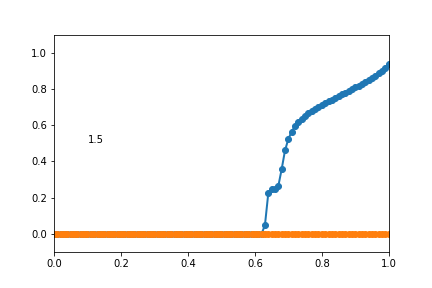
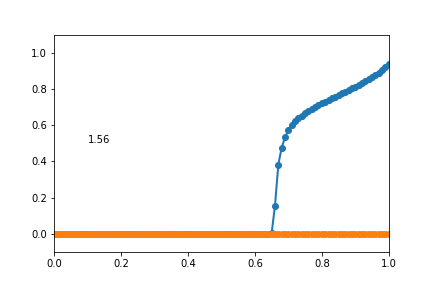
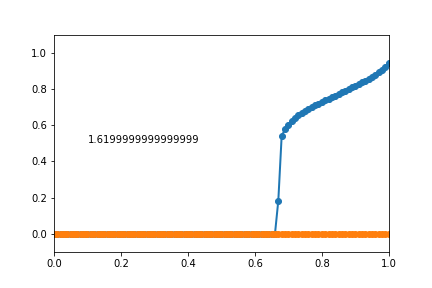
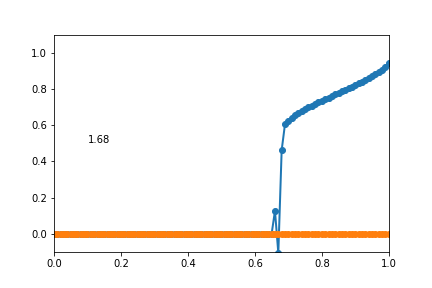
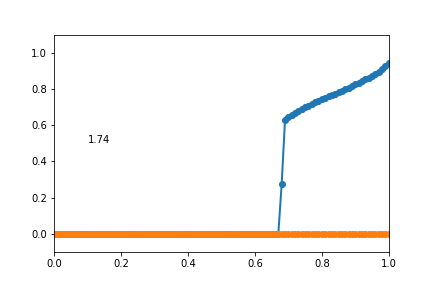
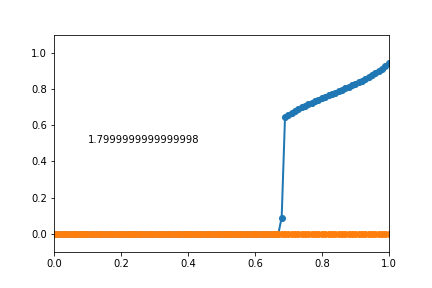
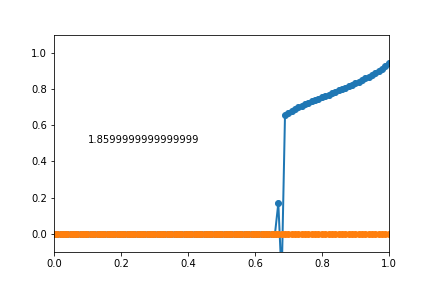
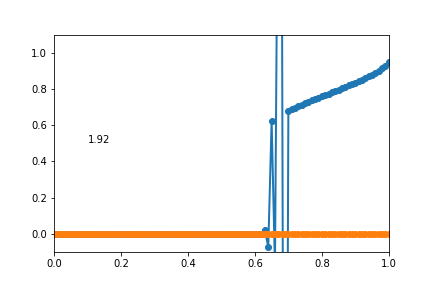
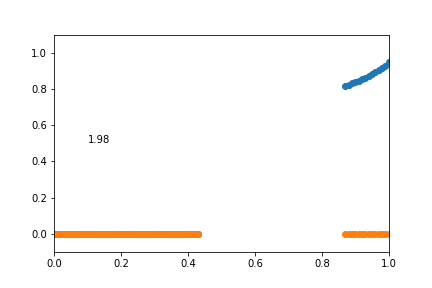
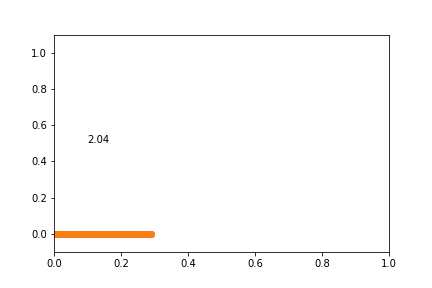
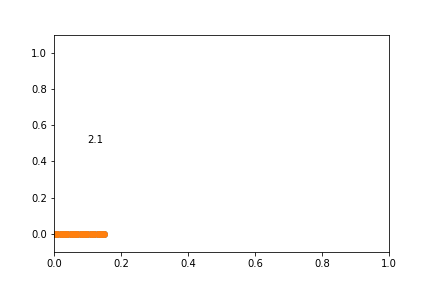
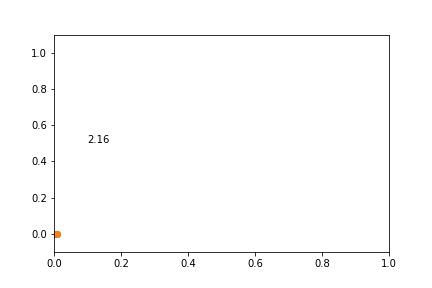
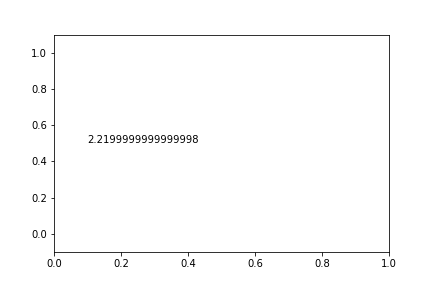
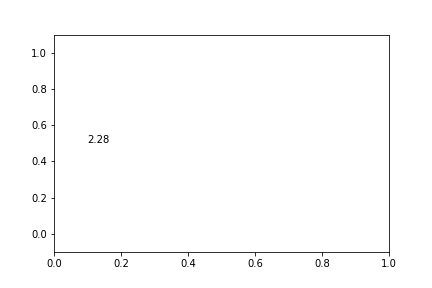
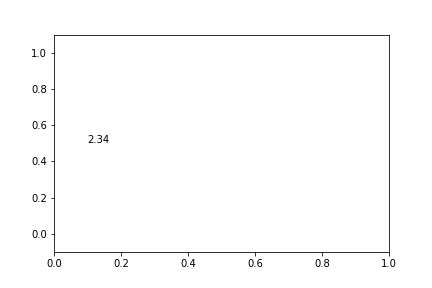
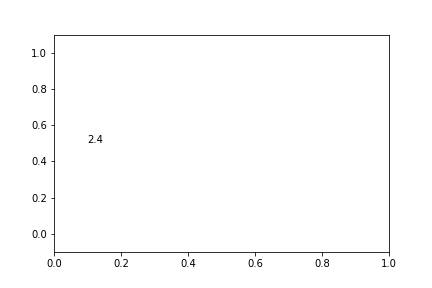
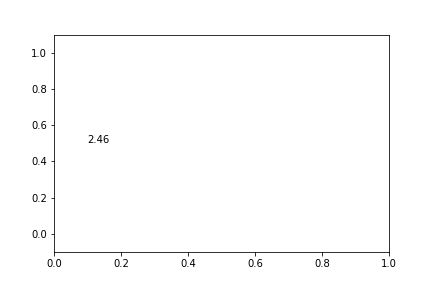
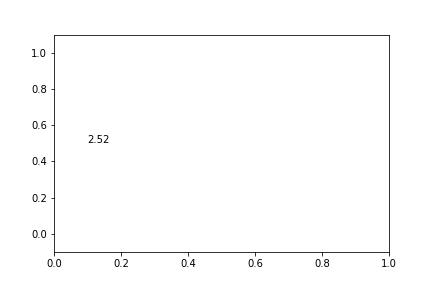
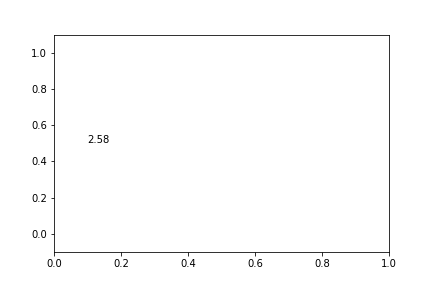
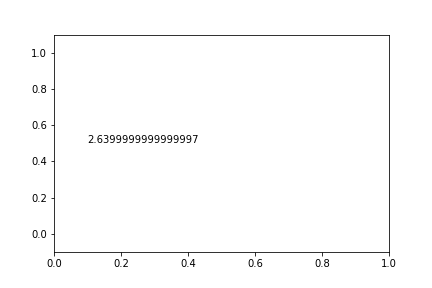
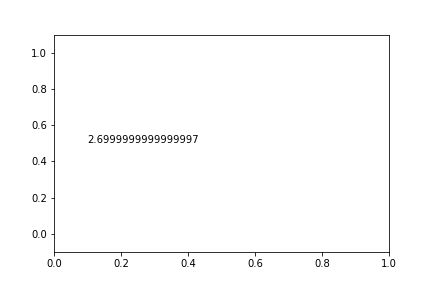
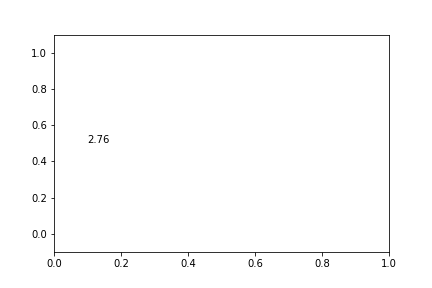
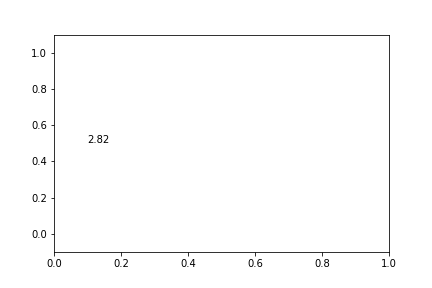
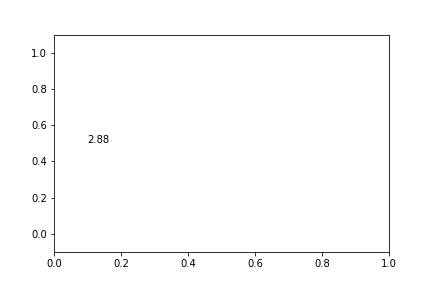
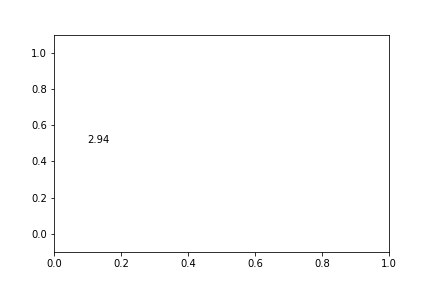
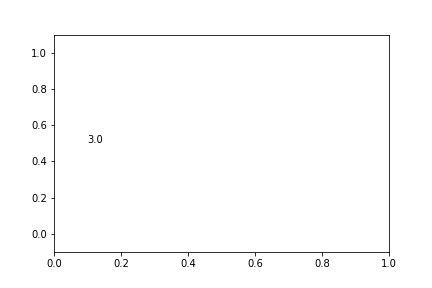

In [9]:
from matplotlib import animation
import matplotlib.pyplot as plt
from clawpack.visclaw.JSAnimation import IPython_display
import numpy as np

# x=domain.grid.x.centers
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-0.1, 1.1))

frame = claw.frames[0]
line1, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
time  = ax.text(0.1,0.5,'hi')

def fplot(frame_number):
    frame = claw.frames[frame_number]
    species1 = frame.q[0,:]
    species2 = frame.q[1,:]
    line1.set_data(xs,species1)
    line2.set_data(xs,species2)
    time.set_text(times[frame_number])
    return line1,line2

animation.FuncAnimation(fig, fplot, frames=len(claw.frames), interval=500)

In [10]:
import importlib
import velocity_functions as vf
importlib.reload(vf)

density = tuple([vf.density[cell] for cell in vf.density])
radius  = tuple([vf.radius[cell] for cell in vf.radius])
order = tuple(vf.radius)
print(order)
speeds = vf.stokes(3000,0.06,radius,density)
print(speeds)
print(0.02*1.56/speeds[0])

('RBC', 'WBC', 'plate', 'bac')
[4.27809e-04 8.30375e-04 2.07853e-05 8.08548e-05]
72.9296762446103


In [24]:
riemann.advection_nonlinear_1D_py.abs_flux(np.array([0.25]),1)#,hsc=vf.michaels)

array([0.10547])

<function velocity_functions.michaels(a, n, amax=0.95)>